# Read SUMMA output

In [6]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('paper', font_scale=1.5)
%matplotlib inline

In [7]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'

## Functions to quickly evaluate all model output

In [8]:
def evalBiasTs(ax, dsDict, obs, labels, ls, lcolor):
    # Tsurf scatter plot
    hours = np.arange(0, 24)
    for ex in sorted(dsDict.keys()):
        ax.plot(dsDict[ex].scalarSurfaceTemp - 273.15, obs.Tsrf, '.',
                label=labels[ex],
                color=lcolor[ex])
    ax.plot([-30, 0], [-30, 0], 'k--')
    ax.set_xlim(-30, 0)
    ax.set_ylim(-30, 0)
    ax.set_xlabel('Modeled T ($^{\circ}$)')
    ax.set_ylabel('Observed T ($^{\circ}$)')
    ax.legend(loc='best')

def sortFun(s):
    if 'high' in s and 'L' in s:
        return(4)
    elif 'high' in s and 'S' in s:
        return(3)
    elif 'low' in s and 'S' in s:
        return(2)
    elif 'low' in s and 'L' in s:
        return(1)
    

## Grab data: observations and model output

In [9]:
# ----------
# Sites and forcing data
siteNames = ['SWA', 'CDP']
siteYears = {'SWA': np.arange(2006, 2012),
             'CDP': np.arange(2002, 2010)}

d1 = {'CDP': datetime(2002, 10, 1), 'SWA': datetime(2006, 10, 1)}
d2 = {'CDP': datetime(2010, 9, 30, 22, 0, 0), 'SWA': datetime(2012, 9, 30, 23, 0, 0)}

os.chdir(dirData)
CDPforce = xr.open_dataset('CDP.ModTsfc.nc')
CDPforce = CDPforce.loc[dict(time = slice(d1['CDP'], d2['CDP']))]
CDPforce_daily = CDPforce.resample(how='mean', freq='d', dim='time')

SWAforce = xr.open_dataset('SWA.ModTsfc.nc')
SWAforce = SWAforce.loc[dict(time = slice(d1['SWA'], d2['SWA']))]
SWAforce_daily = SWAforce.resample(how='mean', freq='d', dim='time')

# ----------
# Summa modeling results for each site
os.chdir(dirData  + '/summaResults')

SWA = xr.open_dataset('SWA.summaResults.forcing.nc')
SWA = xr.concat([SWA, xr.open_dataset('SWA.summaResults.internal.nc')], 'expID')
print(SWA)

CDP = xr.open_dataset('CDP.summaResults.forcing.nc')
CDP = xr.concat([CDP, xr.open_dataset('CDP.summaResults.internal.nc')], 'expID')
print(CDP)

<xarray.Dataset>
Dimensions:                (expID: 45, time: 52608)
Coordinates:
  * time                   (time) datetime64[ns] 2006-10-01 ...
    exp                    (expID) object 'longwaveBias' 'longwaveBias' ...
    family                 (expID) object 'lowLW' 'lowLW' 'highLW' 'highLW' ...
  * expID                  (expID) object 'lowLW_L' 'lowLW_S' 'highLW_S' ...
Data variables:
    scalarRainPlusMelt     (expID, time) float64 -9.999e+03 -9.999e+03 ...
    scalarSWE              (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarSnowSublimation  (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarInfiltration     (expID, time) float64 1.784e-07 3.584e-09 0.0 0.0 ...
    scalarSurfaceRunoff    (expID, time) float64 3.338e-12 7.387e-14 0.0 0.0 ...
    scalarSurfaceTemp      (expID, time) float64 283.1 280.9 279.7 278.8 ...
    scalarSenHeatTotal     (expID, time) float64 -75.53 -20.79 -19.85 -15.34 ...
    scalarLatHeatTotal     (expID, time) float64

In [10]:
# ----------
# Experiment names - Structure Uncertainty
experiments = ['longwaveBias', 'shortwaveBias', 'specHumidBias',
               'airTempBias', 'windBias', 'layers',
               'thermalCond', 'stability']
expMetUnc = ['longwaveBias', 'shortwaveBias', 'specHumidBias',
               'airTempBias', 'windBias']
expIntern = ['layers', 'thermalCond', 'stability']
experimentType = {'forcing': expMetUnc, 'internal': expIntern}
force = {'SWA': SWAforce, 'CDP': CDPforce}
results = {'SWA': SWA, 'CDP': CDP}

# Met uncertainty experiment IDs and values
expNames = {'longwaveBias': ['lowLW_L','lowLW_S', 'highLW_S', 'highLW_L']}
expBias = {'longwaveBias': {'lowLW_L': -25, 'lowLW_S': -10, 'highLW_S': 10, 'highLW_L': 25}}

expNames['shortwaveBias'] = ['lowSW_L','lowSW_S', 'highSW_S', 'highSW_L']
expBias['shortwaveBias'] = {'lowSW_L': -80, 'lowSW_S': -30, 'highSW_S': 30, 'highSW_L': 80}

expNames['specHumidBias'] = ['lowQS_L','lowQS_S', 'highQS_S', 'highQS_L']
expBias['specHumidBias'] = {'lowQS_L': -25,  'lowQS_S': -10, 'highQS_S': 10, 'highQS_L': 25}

expNames['airTempBias'] = ['lowTair_L','lowTair_S', 'highTair_S', 'highTair_L']
expBias['airTempBias'] = {'lowTair_L': -3, 'lowTair_S': -1.5, 'highTair_S': 1.5, 'highTair_L': 3}

expNames['windBias'] = ['lowU_L','lowU_S', 'highU_S', 'highU_L']
expBias['windBias'] = {'lowU_L': -3, 'lowU_S': -1.5, 'highU_S': 1.5, 'highU_L': 3}

metName = {'longwaveBias': 'LWRadAtm',
           'shortwaveBias': 'SWRadAtm',
           'specHumidBias': 'spechum',
           'airTempBias': 'airtemp',
           'windBias': 'windspd'}

metNameTitle = {'longwaveBias': 'Longwave Bias (Wm$^{-2}$)',
           'shortwaveBias': 'Shortwave Bias (Wm$^{-2}$)',
           'specHumidBias': 'Relative Humiditiy Bias (%)',
           'airTempBias': 'Air Temperature Bias ($^{\circ}$C)',
           'windBias': 'Wind Speed Bias (m s$^{-1}$)'}

# Layer
expNames['layers'] = ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010']

# Thermal conductivity
arrayNames = ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']
arrayAppend = ['Mid', 'Low', 'High']
expNames['thermalCond'] = [name + '_' + append for name in arrayNames for append in arrayAppend]

# Stability
arrayAppend = ['Low', 'Mid', 'High']
arrayNames = ['standard', 'louisinv', 'mahrtexp']
expNames['stability'] = [name + '_' + append for name in arrayNames for append in arrayAppend]

internalNames = {'stability': ['standard', 'louisinv', 'mahrtexp'],
                 'layers': ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010'],
                 'thermalCond': ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']}

# ----------
# Scalar variables to extract from output
scalar_data_vars = ['scalarRainPlusMelt', 'scalarSWE', 'scalarSnowSublimation', 
                    'scalarInfiltration', 'scalarSurfaceRunoff', 'scalarSurfaceTemp',
                    'scalarSenHeatTotal', 'scalarLatHeatTotal', 'scalarSnowDepth']

## Assign colors/line types for each experiment

In [11]:
colors = {}
for exp in experiments:
    colors[exp] = kgraph.SRON(np.size(expNames[exp]))
    
# expIDLineStyle = {'Mid': '-',
#                   'Low': '--',
#                   'High': ':'}

In [74]:
def removeOutliers(df, namesIn):
    for n in namesIn:
        tempDF = df.loc[dict(expID=n)]
        sigma = tempDF.std(dim='time')
        mu = tempDF.mean(dim='time')
        tempDF[tempDF > mu + 3 * sigma] = np.nan
        tempDF[tempDF < mu - 3 * sigma] = np.nan
        df.loc[dict(expID=n)] = tempDF
    return(df)

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


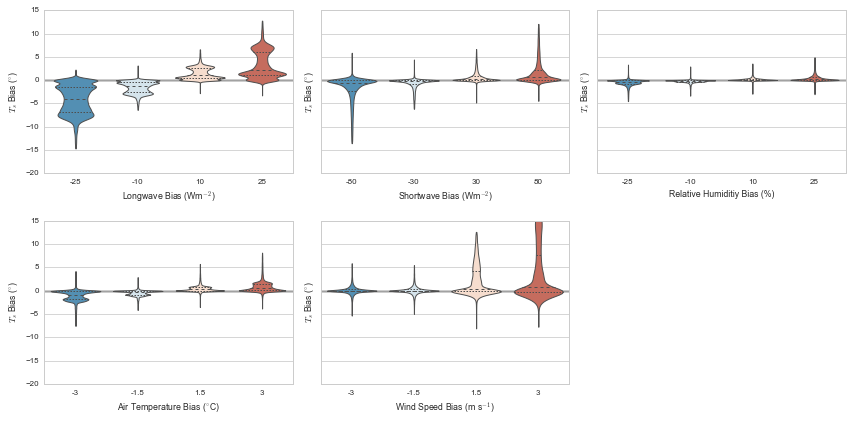

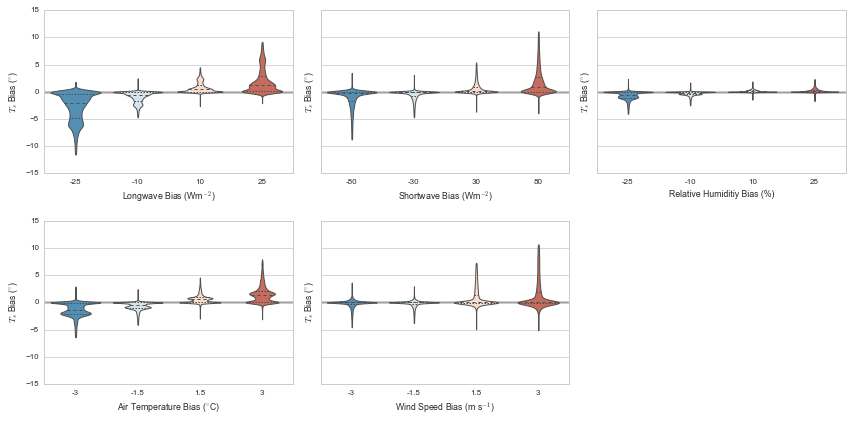

In [104]:
# ----------
# Met uncertainty
flag_modelRelative = True
for s in siteNames:
    fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True)
    axes = axes.flatten()

    # Violin plots
    for numExp, exp in enumerate(expMetUnc):
        if exp in expMetUnc:
            ax = axes[numExp]
            tempDS = results[s].sel(expID=expNames[exp])
            
            # Bias relative to model with no errors
            if flag_modelRelative:
                noBias = results[s].sel(expID='jrdn1991')
                df = ((tempDS.scalarSurfaceTemp) - noBias.scalarSurfaceTemp)
                df = df.where((tempDS.scalarSWE > 0) & (noBias.scalarSWE > 0))
                # Remove extreme outliers
                df = removeOutliers(df, expNames[exp])

            # Bias relative to observations
            else:
                df = ((tempDS.scalarSurfaceTemp - 273.15) - force[s].Tsrf)
                df = df.where((force[s].SP) & (tempDS.scalarSWE > 0))
                # Remove extreme outliers
                df = removeOutliers(df, expNames[exp])

            df = df.to_dataframe(name='bias').reset_index()
            ax = sns.violinplot(x='expID', y='bias', data=df, cut=0, ax=ax,
                                scale='count', inner='quartile', linewidth=1,
                                order=sorted(list(expBias[exp].keys()), key=sortFun),
                                palette="RdBu_r")
    # Formatting
    for numExp, exp in enumerate(expMetUnc):
            ax = axes[numExp]
            ax.set_xticklabels(sorted(list(expBias[exp].values())));
            ax.set_xlabel(metNameTitle[exp])
            if s == 'CDP':
                ax.set_ylim(-15, 15)
            elif s == 'SWA':
                ax.set_ylim(-20, 15)
            ax.set_ylabel('$T_{s}$ Bias ($^{\circ}$)')
            ax.plot([-10, 10], [0, 0], 'k', zorder=0)
    axes[-1].axis('off')

    # Save figure
    fig.tight_layout()
    os.chdir(dirPrint)
    if flag_modelRelative:
        fig.savefig(s + '.forcing.biasModelRelative_Ts.violins.pdf', bbox_inches='tight')
    else:
        fig.savefig(s + '.forcing.bias_Ts.violins.pdf', bbox_inches='tight')

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


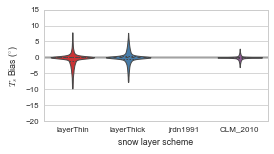

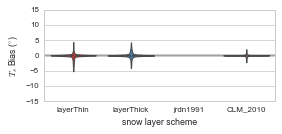

In [66]:
# ----------
# Internal Decisions: layers
flag_modelRelative = True
for s in siteNames:
    fig, ax = plt.subplots(1, 1, figsize=(4, 2), sharey=True)

    # Violin plots
    exp = 'layers'
    tempDS = results[s].sel(expID=expNames[exp])
            
    # Bias relative to model with no errors
    if flag_modelRelative:
        noBias = results[s].sel(expID='jrdn1991')
        df = ((tempDS.scalarSurfaceTemp) - noBias.scalarSurfaceTemp)
        df = df.where((tempDS.scalarSWE > 0) & (noBias.scalarSWE > 0))
        # Remove extreme outliers
        df = removeOutliers(df, expNames[exp])

    # Bias relative to observations
    else:
        df = ((tempDS.scalarSurfaceTemp - 273.15) - force[s].Tsrf)
        df = df.where((force[s].SP) & (tempDS.scalarSWE > 0))
        # Remove extreme outliers
        df = removeOutliers(df, expNames[exp])

    df = df.to_dataframe(name='bias').reset_index()
    ax = sns.violinplot(x='expID', y='bias', data=df, cut=0, ax=ax,
                        scale='count', inner='quartile', linewidth=1,
                        palette="Set1")

    # Formatting
    ax.set_xlabel('snow layer scheme')
    if s == 'CDP':
        ax.set_ylim(-15, 15)
    elif s == 'SWA':
        ax.set_ylim(-20, 15)
    ax.set_ylabel('$T_{s}$ Bias ($^{\circ}$)')
    ax.plot([-10, 10], [0, 0], 'k', zorder=0)

# Save figure
fig.tight_layout()
os.chdir(dirPrint)
if flag_modelRelative:
    fig.savefig(s + '.layer.biasModelRelative_Ts.violins.pdf', bbox_inches='tight')
else:
    fig.savefig(s + '.layer.bias_Ts.violins.pdf', bbox_inches='tight')

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


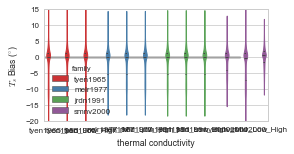

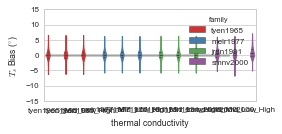

In [86]:
# ----------
# Internal Decisions: layers
flag_modelRelative = False
for s in siteNames:
    fig, ax = plt.subplots(1, 1, figsize=(4, 2), sharey=True)

    # Violin plots
    exp = 'thermalCond'
    tempDS = results[s].sel(expID=expNames[exp])
            
    # Bias relative to model with no errors
    if flag_modelRelative:
        noBias = results[s].sel(expID='jrdn1991')
        df = ((tempDS.scalarSurfaceTemp) - noBias.scalarSurfaceTemp)
        df = df.where((tempDS.scalarSWE > 0) & (noBias.scalarSWE > 0))
        # Remove extreme outliers
        df = removeOutliers(df, expNames[exp])

    # Bias relative to observations
    else:
        df = ((tempDS.scalarSurfaceTemp - 273.15) - force[s].Tsrf)
        df = df.where((force[s].SP) & (tempDS.scalarSWE > 0))
        # Remove extreme outliers
        df = removeOutliers(df, expNames[exp])

    df = df.to_dataframe(name='bias').reset_index()
    ax = sns.violinplot(x='expID', y='bias', hue='family', data=df, cut=0, ax=ax,
                        scale='count', inner='quartile', linewidth=1,
                        palette="Set1")

    # Formatting
    ax.set_xlabel('thermal conductivity')
    if s == 'CDP':
        ax.set_ylim(-15, 15)
    elif s == 'SWA':
        ax.set_ylim(-20, 15)
    ax.set_ylabel('$T_{s}$ Bias ($^{\circ}$)')
    ax.plot([-10, 10], [0, 0], 'k', zorder=0)

# Save figure
fig.tight_layout()
os.chdir(dirPrint)
if flag_modelRelative:
    fig.savefig(s + '.thermalCond.biasModelRelative_Ts.violins.pdf', bbox_inches='tight')
else:
    fig.savefig(s + '.thermalCond.bias_Ts.violins.pdf', bbox_inches='tight')

//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive
//anaconda/lib/python3.5/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in less
  if not reflexive


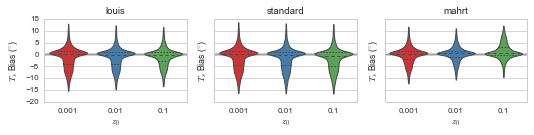

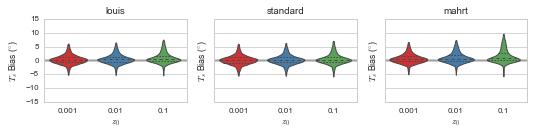

In [268]:
# ----------
# Internal Decisions: layers
flag_modelRelative = False
for s in siteNames:
    fig, axes = plt.subplots(1, 3, figsize=(7.5, 2), sharey=True)
    axes = axes.flatten()

    # Violin plots
    exp = 'stability'
    stabNames = ['louis', 'standard', 'mahrt']
    for num, sN in enumerate(stabNames):
        ax = axes[num]
        stab = [stab for stab in expNames[exp] if sN in stab]
        tempDS = results[s].sel(expID=stab)

        # Bias relative to model with no errors
        if flag_modelRelative:
            noBias = results[s].sel(expID='jrdn1991')
            df = ((tempDS.scalarSurfaceTemp) - noBias.scalarSurfaceTemp)
            df = df.where((tempDS.scalarSWE > 0) & (noBias.scalarSWE > 0))
            # Remove extreme outliers
            df = removeOutliers(df, stab)

        # Bias relative to observations
        else:
            df = ((tempDS.scalarSurfaceTemp - 273.15) - force[s].Tsrf)
            df = df.where((force[s].SP) & (tempDS.scalarSWE > 0))
            # Remove extreme outliers
            df = removeOutliers(df, stab)

        df = df.to_dataframe(name='bias').reset_index()
        ax = sns.violinplot(x='expID', y='bias', data=df, cut=0, ax=ax,
                            scale='count', inner='quartile', linewidth=1,
                            palette="Set1")

        # Formatting
        ax.set_xlabel('$z_0$')
        ax.set_xticklabels([0.001, 0.01, 0.1])
        ax.set_title(sN)
        if s == 'CDP':
            ax.set_ylim(-15, 15)
        elif s == 'SWA':
            ax.set_ylim(-20, 15)
        ax.set_ylabel('$T_{s}$ Bias ($^{\circ}$)')
        ax.plot([-10, 10], [0, 0], 'k', zorder=0)

    # Save figure
    fig.tight_layout()
    os.chdir(dirPrint)
    if flag_modelRelative:
        fig.savefig(s + '.stability.biasModelRelative_Ts.violins.pdf', bbox_inches='tight')
    else:
        fig.savefig(s + '.stability.bias_Ts.violins.pdf', bbox_inches='tight')